# Remove Image Distortion
###### In this assignment, we try to remove the projective distortion of an image caused by the angle of camera relative to the normal of the target picture
## Remove Projective Distortion
###### First, we remove the inherent projective distortion by getting the transformation matrix causing it.

In [1]:
import numpy as np
import math
import scipy
from skimage import io
import matplotlib.pyplot as plt

Import image file

In [2]:
img = io.imread("sample1.jpg")
img_size = img.shape

Initialize the 4 corner point of the image you want to rectify

In [3]:
ptl=np.array([236, 478, 1], dtype=np.int64) #top left point
ptr=np.array([651, 424, 1], dtype=np.int64) #top right point
pbr=np.array([665, 795, 1], dtype=np.int64) #bottom left point
pbl=np.array([269, 795, 1], dtype=np.int64) #bottom right point

Get the 'supposed' parallels line l1,l2 and m1,m2 and get the intersecting points and the line it forms

In [4]:
l1=np.cross(ptl, ptr) #top line
l2=np.cross(pbl, pbr) #bottom line
m1=np.cross(ptl, pbl) #left line
m2=np.cross(ptr, pbr) #right line
intp1=np.cross(l1,l2) #intersecting point of top and bottom line
intp2=np.cross(m1,m2) #intersecting point of left and right line
vanline=np.cross(intp1,intp2) #vanishing line
vanline=vanline/np.linalg.norm(vanline)
vanline=vanline/vanline[2]

Matrix H is the transformation matrix for the distortion from projective to affine

In [5]:
H=np.array([[1,0,0],[0,1,0], vanline], dtype='float64')

Get the new boundaries of the affine distorted image

In [6]:
boundaries=np.array([[1, img_size[1], img_size[1], 1],[1, 1, img_size[0], img_size[0]],[1,1,1,1]])
tl=np.matmul(H,boundaries[:,0])
tl=tl/tl[2]
tr=np.matmul(H,boundaries[:,1])
tr=tr/tr[2]
bt=np.matmul(H,boundaries[:,2])
bt=bt/bt[2]
br=np.matmul(H,boundaries[:,3])
br=br/br[2]
point_boundaries=np.array([tl,tr,bt,br])
new_boundaries=([max(point_boundaries[:,0]), max(point_boundaries[:,1])])
new_boundaries=([math.ceil(new_boundaries[0]),math.ceil(new_boundaries[1])])

Placeholder of the affine distorted image

In [7]:
proj_img=np.zeros((new_boundaries[1],new_boundaries[0],3), dtype='i8')

Apply the transformation matrix H to the projective distorted image to get the affine distorted image

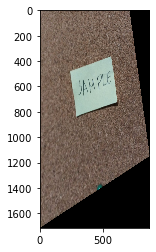

In [8]:
for x in range(new_boundaries[0]):
    for y in range(new_boundaries[1]):
        xy = np.array([[x+1],[y+1],[1]])
        orig_point = np.linalg.solve(H,xy)
        orig_point[0] = np.round(orig_point[0]/orig_point[2])
        orig_point[1] = np.round(orig_point[1]/orig_point[2])
        orig_point[2] = np.round(orig_point[2]/orig_point[2])
        orig_point = np.array(orig_point, dtype='i8')
        
        if orig_point[0] < img_size[1] and orig_point[1] < img_size[0]:
            if orig_point[0] > 0 and orig_point[1] > 0:
                proj_img[y,x,:]=img[orig_point[1],orig_point[0],:]
                
                new_point=np.array([orig_point[0][0],orig_point[1][0],orig_point[2][0]],dtype='i8')
                if np.array_equal(new_point,ptl):
                    nptl = [x+1,y+1,1]
                if np.array_equal(new_point,ptr):
                    nptr = [x+1,y+1,1]
                if np.array_equal(new_point,pbr):
                    npbr = [x+1,y+1,1]
                if np.array_equal(new_point,pbl):
                    npbl = [x+1,y+1,1]
     
plt.imshow(proj_img, cmap='gray', interpolation='nearest') 

## Remove Affine Distortion
###### We can now then remove the affine distortion of the image to the get the right image

Get the new lines of the affine distorted image

In [9]:
pl1=np.cross(npbl, nptl) #new top line
pm1=np.cross(nptl, nptr) #new bottom line
pl2=np.cross(nptl, npbr) #new left line
pm2=np.cross(nptr, npbl) #new right line
l11 = pl1[0]
l12 = pl1[1]
l21 = pl2[0]
l22 = pl2[1]
m11 = pm1[0]
m12 = pm1[1]
m21 = pm2[0]
m22 = pm2[1]

Solve for S in order to get the matrix A, the (2x2) transformation matrix of affine distorted image.

Then we can transform it into (3x3) tranformation matrix H2.

In [10]:
s11 = np.array([l11*m11, l11*m12 + l12*m11, l12*m12])
s22 = np.array([l21*m21, l21*m22 + l22*m21, l22*m22])
s = np.array([s11, s22])
s = scipy.linalg.null_space(s)
S = np.array([[s[0][0],s[1][0]],[s[1][0],1]])

U, D, V = np.linalg.svd(S)
D = np.array([[D[0], 0],[0,D[1]]])
A = np.matmul(np.conjugate(U),np.sqrt(D))
A = np.matmul(A,U)
H2= np.array([[A[0][0],A[0][1],0],[A[1][0],A[1][1],0],[0,0,1]])

Find the new boundaries of the rectified image

In [11]:
new_size=new_boundaries
boundaries=np.array([[1, new_size[0]],[1,new_size[1]],[1,1]])
bound=np.reshape(boundaries[:,1],(3,1))
fin_bound=np.linalg.solve(H2,bound)
fin_bound=np.ceil(fin_bound)
fin_bound=np.array(fin_bound, dtype='i8')
fin_img=np.zeros((fin_bound[1][0],fin_bound[0][0],3), dtype='i8')
print(H2)

[[ 0.76488292 -0.06301108  0.        ]
 [-0.06301108  0.99801283  0.        ]
 [ 0.          0.          1.        ]]


Apply the transformation matrix H2 to the affine distorted image to get the rectified image

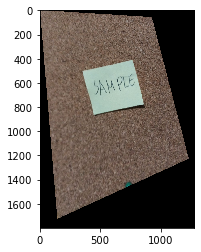

In [12]:
for x in range(fin_bound[0][0]):
    for y in range(fin_bound[1][0]):
        xy = np.array([[x+1],[y+1],[1]])
        rect_point = np.matmul(H2,xy)
        rect_point[0] = np.round(rect_point[0]/rect_point[2])
        rect_point[1] = np.round(rect_point[1]/rect_point[2])
        rect_point[2] = np.round(rect_point[2]/rect_point[2])
        rect_point = np.array(rect_point, dtype='i8')
        
        if rect_point[0] < new_size[0] and rect_point[1] < new_size[1]:
            if rect_point[0] > 0 and rect_point[1] > 0:
                fin_img[y,x,:]=proj_img[rect_point[1],rect_point[0],:]
                
                fin_point=np.array([rect_point[0][0],rect_point[1][0],rect_point[2][0]],dtype='i8')
                if np.array_equal(fin_point,ptl):
                    fptl = np.array([x+1,y+1,1])
                if np.array_equal(fin_point,ptr):
                    fptr = np.array([x+1,y+1,1])
                if np.array_equal(fin_point,pbr):
                    fpbr = np.array([x+1,y+1,1])
                if np.array_equal(fin_point,pbl):
                    fpbl = np.array([x+1,y+1,1])

plt.imshow(fin_img, cmap='gray', interpolation='nearest')

The final image may still require rotation transformation in order to be perfectly rectified